### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line
import math

### Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [2]:
#!unzip data.zip

### Defining the Dataset Class

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
class Cell_data(Dataset):
    def __init__(self, data_dir, size, train = True, train_test_split = 0.8, augment_data = True, transform = None):
        ##########################inputs##################################
        #data_dir(string) - directory of the data#########################
        #size(int) - size of the images you want to use###################
        #train(boolean) - train data or test data#########################
        #train_test_split(float) - the portion of the data for training###
        #augment_data(boolean) - use data augmentation or not#############
        super(Cell_data, self).__init__()
        # todo
        #initialize the data class
        self.image_files = os.listdir(data_dir+"/scans")
        self.transform = transform
        train_test_split = math.floor(train_test_split*len(self.image_files))

        self.augmented_images_dir = data_dir+"/augmented_data"
        if not os.path.exists(self.augmented_images_dir):
            os.mkdir(self.augmented_images_dir)

        random.shuffle(self.image_files)
        if train == True:
            train_image_files = self.augmented_images_dir+"/train"
            os.mkdir(train_image_files)
            os.mkdir(train_image_files+"/scans")
            os.mkdir(train_image_files+"/labels")
            self.final_images_dir = train_image_files
            dataset_for_augmentation = self.image_files[:train_test_split]
        else:
            test_image_files = self.augmented_images_dir+"/test"
            os.mkdir(test_image_files)
            os.mkdir(test_image_files+"/scans")
            os.mkdir(test_image_files+"/labels")
            self.final_images_dir = test_image_files
            dataset_for_augmentation = self.image_files[train_test_split:]

        image_count=1
        for image in dataset_for_augmentation:
            scan_image = Image.open(data_dir+"/scans/"+image)
            scan_image = scan_image.resize((size, size))
            label_image = Image.open(data_dir+"/labels/"+image)
            label_image = label_image.resize((size, size))
            #data augmentation part
            if augment_data:
                augment_mode = np.random.randint(0, 3)
                if augment_mode == 0:
                    #flip image vertically
                    augmented_scan_image_1 = TF.vflip(scan_image)
                    augmented_label_image_1 = TF.vflip(label_image)

                    #flip image horizontally
                    augmented_scan_image_2 = TF.hflip(scan_image)
                    augmented_label_image_2 = TF.hflip(label_image)

                elif augment_mode == 1:
                    #rotate image
                    angle = random.randint(-30, 30)
                    augmented_scan_image_1 = TF.rotate(scan_image, angle)
                    augmented_label_image_1 = TF.rotate(label_image, angle)

                    #Gamma correction
                    gamma = random.randrange(3,8)/10
                    augmented_scan_image_2 = TF.adjust_gamma(scan_image, gamma)
                    augmented_label_image_2 = label_image

                else:
                    #Non Rigid Transformation
                    shear_angle = random.randint(-20,20)
                    augmented_scan_image_1 = TF.affine(scan_image, angle=0, translate=(0,0), scale = 1.0, shear=shear_angle)
                    augmented_label_image_1 = TF.affine(label_image, angle=0, translate=(0,0), scale = 1.0, shear=shear_angle)

                    #flip image horizontally
                    augmented_scan_image_2 = TF.hflip(scan_image)
                    augmented_label_image_2 = TF.hflip(label_image)

                    #zoom image
                    #zoom_size = random.randint(int(self.size*0.75), self.size)
                    #augmented_scan_image_2 = TF.center_crop(scan_image, zoom_size)
                    #augmented_label_image_2 = TF.center_crop(label_image, zoom_size)
                
                #write the files to the augmented data location
                scan_image.save(self.final_images_dir+"/scans/"+str(image_count)+".bmp") # original image is saved as 1.bmp
                augmented_scan_image_1.save(self.final_images_dir+"/scans/"+str(image_count+1)+".bmp") # augmented image is saved as 2.jpg
                augmented_scan_image_2.save(self.final_images_dir+"/scans/"+str(image_count+2)+".bmp") # augmented image is saved as 3.jpg

                label_image.save(self.final_images_dir+"/labels/"+str(image_count)+".bmp") # original label is saved as 1.bmp
                augmented_label_image_1.save(self.final_images_dir+"/labels/"+str(image_count+1)+".bmp") # augmented label is saved as 2.jpg
                augmented_label_image_2.save(self.final_images_dir+"/labels/"+str(image_count+2)+".bmp") # augmented label is saved as 3.jpg

                image_count+=3
        
        self.dataset = os.listdir(self.final_images_dir+"/scans")


    def __getitem__(self, idx):
        # todo
        #load image and mask from index idx of your data
        filename = self.dataset[idx]
        scan_image = Image.open(self.final_images_dir+"/scans/"+filename)
        label_image = Image.open(self.final_images_dir+"/labels/"+filename)
        #todo
        #return image and mask in tensors

        return self.transform(scan_image), torch.ceil(self.transform(label_image))

    def __len__(self):
        return len(self.dataset)

### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [5]:
TEMP = False
class twoConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(twoConvBlock, self).__init__()
        #todo
        #initialize the block
        self.conv_layer1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1)
        self.conv_layer2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1)
        self.batch_norm_layer = nn.BatchNorm2d(output_channels)

    def forward(self, image):
        #todo
        #implement the forward path
        image = self.conv_layer1(image)
        image = F.relu(image)
        image = self.conv_layer2(image)
        image = self.batch_norm_layer(image)
        image = F.relu(image)
        return image

class downStep(nn.Module):
    def __init__(self):
        super(downStep, self).__init__()
        #todo
        #initialize the down path
        self.max_pool_layer = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self, image):
        #todo
        #implement the forward path
        image = self.max_pool_layer(image)
        return image

class upStep(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(upStep, self).__init__()
        #todo
        #initialize the up path
        self.up_sampling_layer = nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2)

    def forward(self, image):
        #todo
        #implement the forward path
        image = self.up_sampling_layer(image)
        return image

def crop_tensor(input_copy, ideal_size):
    h_delta = (input_copy.shape[2]-ideal_size.shape[2]) // 2
    w_delta = (input_copy.shape[3]-ideal_size.shape[3]) // 2
    return input_copy[:,:,h_delta:input_copy.shape[2]-h_delta, w_delta:input_copy.shape[3]-w_delta]

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        #todo
        #initialize the complete model
        self.conv1 = twoConvBlock(1, 64)
        self.conv2 = twoConvBlock(64, 128)
        self.conv3 = twoConvBlock(128, 256)
        self.conv4 = twoConvBlock(256, 512)
        self.conv5 = twoConvBlock(512, 1024)
        self.conv6 = twoConvBlock(1024, 512)
        self.conv7 = twoConvBlock(512, 256)
        self.conv8 = twoConvBlock(256, 128)
        self.conv9 = twoConvBlock(128, 64)
        self.conv10 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1)
        self.down_step = downStep()
        self.up_step1 = upStep(1024, 512)
        self.up_step2 = upStep(512, 256)
        self.up_step3 = upStep(256,128)
        self.up_step4 = upStep(128,64)

    def forward(self, input):
        #todo
        #implement the forward path
        conv1_op = self.conv1(input)
        down_sampled = self.down_step(conv1_op)
        conv2_op = self.conv2(down_sampled)
        down_sampled = self.down_step(conv2_op)
        conv3_op = self.conv3(down_sampled)
        down_sampled = self.down_step(conv3_op)
        conv4_op = self.conv4(down_sampled)
        down_sampled = self.down_step(conv4_op)
        conv5_op = self.conv5(down_sampled)
        up_sampled = self.up_step1(conv5_op)
        # Conv 6 output is the one below
        conv_op = self.conv6(torch.cat(tensors=(up_sampled, crop_tensor(conv4_op, up_sampled)), dim=1))
        up_sampled = self.up_step2(conv_op)
        conv_op = self.conv7(torch.cat(tensors=(up_sampled, crop_tensor(conv3_op, up_sampled)), dim=1))
        up_sampled = self.up_step3(conv_op)
        conv_op = self.conv8(torch.cat(tensors=(up_sampled, crop_tensor(conv2_op, up_sampled)), dim=1))
        up_sampled = self.up_step4(conv_op)
        conv_op = self.conv9(torch.cat(tensors=(up_sampled, crop_tensor(conv1_op, up_sampled)), dim=1))
        conv_op = self.conv10(conv_op)

        return conv_op


### Training

In [6]:
import wandb

wandb.init(project="U-Net_Model")

wandb.config = {
  "learning_rate": 0.01,
  "epochs": 80,
  "batch_size": 2,
  "weight_decay": 0.0005
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: charan250498. Use `wandb login --relogin` to force relogin


In [7]:
#Paramteres

#learning rate
lr = 1e-4

#number of training epochs
epoch_n = 0

#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 2

#use checkpoint model for training
load = True

#use GPU for training
gpu = True

data_dir = os.path.join(root_dir, 'data/cells')

trainset = Cell_data(data_dir = data_dir, size = image_size, transform = transform)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False, transform = transform)
testloader = DataLoader(testset, batch_size = batch_size)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)

if load:
    print('loading model')
    model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=0.0005)

loading model


In [9]:
model.train()
for e in range(epoch_n):
    epoch_loss = 0
    model.train()
    for i, data in enumerate(trainloader):
        image, label = data

        image = image.to(device)
        label = label.long().to(device)

        pred = model(image)

        crop_x = (label.shape[2] - pred.shape[2]) // 2
        crop_y = (label.shape[3] - pred.shape[3]) // 2

        label = label[:, :, crop_x: label.shape[2] - crop_x, crop_y: label.shape[3] - crop_y]

        pred = torch.squeeze(pred,1)
        label = torch.squeeze(label,1)
    
        loss = criterion(pred, label)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

        #print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size)) ############################# Uncomment this later
    print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))

    wandb.log({"Train loss": epoch_loss / trainset.__len__()})

    torch.save(model.state_dict(), 'checkpoint.pt')

    model.eval()

    total = 0
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(testloader):
            image, label = data

            image = image.to(device)
            label = label.long().to(device)

            pred = model(image)
            crop_x = (label.shape[2] - pred.shape[2]) // 2
            crop_y = (label.shape[3] - pred.shape[3]) // 2

            label = label[:, :, crop_x: label.shape[2] - crop_x, crop_y: label.shape[3] - crop_y]
            
            pred = torch.squeeze(pred,1)
            label = torch.squeeze(label,1)

            loss = criterion(pred, label)
            total_loss += loss.item()

            _, pred_labels = torch.max(pred, dim = 1)

            total += label.shape[0] * label.shape[1] * label.shape[2]
            correct += (pred_labels == label).sum().item()

        print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))

        wandb.log({"Accuracy": correct * 100 / total})
        wandb.log({"Test loss": total_loss / testset.__len__()})

wandb.watch(model)

[]

### Testing and Visualization

In [ ]:
model.eval()

output_masks = []
output_labels = []

def Threshold(label, output):
    pass

with torch.no_grad():
    for i in range(testset.__len__()):
        image, labels = testset.__getitem__(i)
    
        input_image = image.unsqueeze(0).to(device)
        pred = model(input_image)

        output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()#.astype(np.float32)

        labels = labels[0]
        crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
        crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
        labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()
    
        output_masks.append(output_mask)
        output_labels.append(labels)

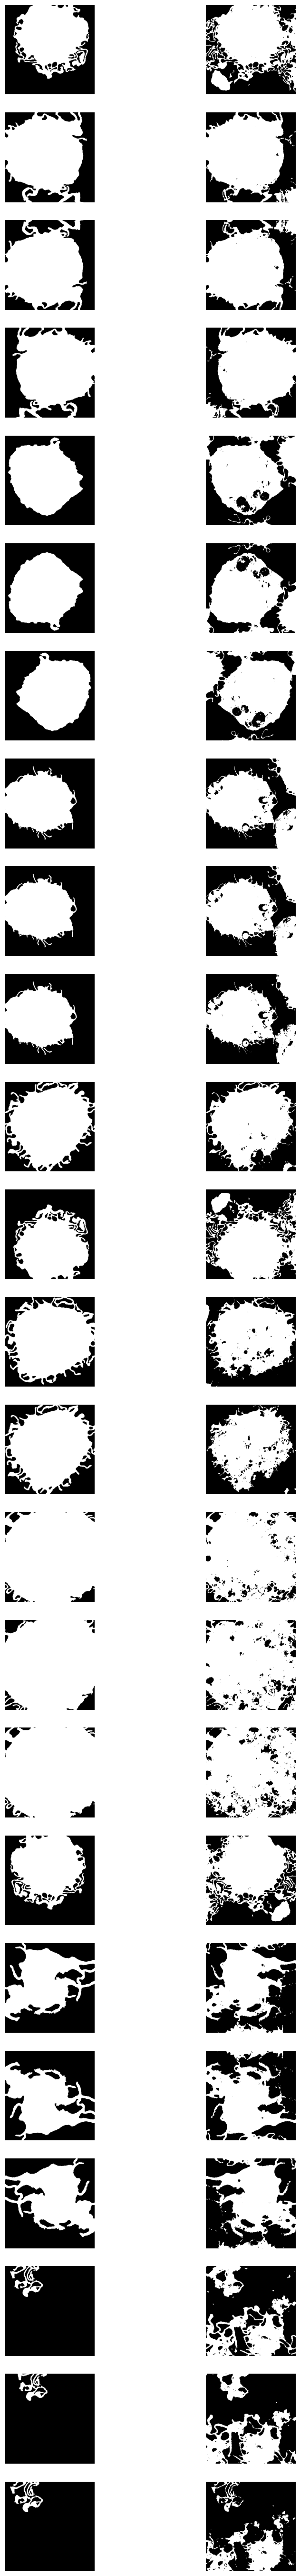

In [ ]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (10, 70))

for i in range(testset.__len__()):
    axes[i, 0].imshow(output_labels[i],cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(output_masks[i],cmap='gray')
    axes[i, 1].axis('off')